In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
cur_path = "/content/drive/MyDrive/BDB 2024/"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/BDB 2024


In [2]:
!pip install pyspark

# The entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[4]").appName("DataFrame").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=cb517549c921244d6989cb0c976dbbdec09f15db69a1f4a701e29a98a1c3262b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import sqrt

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [7]:
games = spark.read.option("header",'True').csv('./nfl-big-data-bowl-2024/games.csv')
tracking = spark.read.parquet("./data_for_model.parquet")
players = spark.read.option("header",'True').csv('./nfl-big-data-bowl-2024/players.csv')
plays = spark.read.option("header",'True').csv('./nfl-big-data-bowl-2024/plays.csv')

In [8]:
tracking = tracking.join(players.select(['nflId','position']),on=['nflId'])
tracking = tracking.join(plays.select(['gameId','playId','offenseFormation','defendersInTheBox']),on=['gameId','playId'])
tracking = tracking.filter(tracking['offenseFormation']!='NA')

# Split Data

Split the data into a training set and a testing set. The training set will consist of 80% of the data (which should be weeks 1-7) and the test data will be 20% (should be week 8).

In [9]:
# print(tracking.shape)
# tracking = tracking.merge(games[['gameId','week']], how='left', on=['gameId'])
total_columns = games.columns
for i in range(len(total_columns)):
    games = games.withColumnRenamed(total_columns[i],
                                  total_columns[i] + '_games')
tracking = tracking.join(games.select(['gameId_games','week_games']), on=(tracking.gameId==games.gameId_games) )
# print(tracking.shape)
# tracking.head()

In [10]:
# convert all fields to integers (necessary for normalization)

# train.select(min('s_carrier'))
from pyspark.sql.types import IntegerType

# train.withColumn("s_carrier", train["s_carrier"].cast(IntegerType()))

total_columns = tracking.columns
for i in range(len(total_columns)):
  if total_columns[i] in ['X_std', 'Y_std', 'dir_std', 's', 'a', 'o_std', 'X_std_carrier', 'Y_std_carrier', 's_carrier', 'dir_std_carrier', 'a_carrier',
                  'o_std_carrier', 'dist_to_carrier', 'dist_to_blocker', 'pursuit_angle', 'down', 'yardsToGo', 'yardlineNumber', 'defendersInTheBox']:
    # print(total_columns[i])
    tracking = tracking.withColumn( total_columns[i], tracking[total_columns[i]].cast(IntegerType()))

# Normalization

We must normalize the data so the model doesn't think that features with wider ranges are more valuable. Normalize both the inputs and outputs based on this article (https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)

If time permits, then use column distribution to determine if standardization/normalization should be used.

In [11]:
# normalize all non-ID/label fields
for column in tracking.columns:
    if column in ['X_std', 'Y_std', 'dir_std', 's', 'a', 'o_std', 'X_std_carrier', 'Y_std_carrier', 's_carrier', 'dir_std_carrier', 'a_carrier',
                  'o_std_carrier', 'dist_to_carrier', 'dist_to_blocker', 'down', 'yardsToGo', 'yardlineNumber', 'defendersInTheBox']:

        min = tracking.agg({column: 'min'}).collect()[0][0]
        max = tracking.agg({column: 'max'}).collect()[0][0]
        #train = train.withColumn( column, (train[column] - train.agg(min(train[column]).alias("min")).collect()[0]["min"]) / (train.agg(max(train[column]).alias("max")).collect()[0]["max"] - train.agg(min(train[column]).alias("min")).collect()[0]["min"]))
        # train = train.withColumn( column, (train[column] - min) / (max - min))
        # test = test.withColumn( column, (test[column] - min) / (max - min))
        tracking = tracking.withColumn( column, (tracking[column] - min) / (max - min))

In [12]:
# FIXME to weeks 1-7
# train = tracking[tracking['week']==1]
train = tracking.filter(tracking['week_games']<8)
# FIXME to week == 8
# test = tracking[tracking['week']==1]
test = tracking.filter(tracking['week_games']==8)

# Modeling

Baseline model will be the RMSE if we use the median pursuit angle as the predicted value.

In [13]:
y = 'pursuit_angle'

# features = ['gameId','playId','frameId','nflId', 'X_std', 'Y_std', 'dir_std', 's', 'a', 'o_std', 'X_std_carrier', 'Y_std_carrier', 's_carrier', 'dir_std_carrier',
#            'a_carrier', 'o_std_carrier','dist_to_carrier', 'dist_to_blocker']
features = ['X_std', 'Y_std', 'dir_std', 's', 'a', 'o_std', 'X_std_carrier', 'Y_std_carrier', 's_carrier', 'dir_std_carrier',
           'a_carrier', 'o_std_carrier','dist_to_carrier', 'dist_to_blocker', 'down', 'yardsToGo', 'yardlineNumber','offenseFormation_Vec','position_Vec',
            'defendersInTheBox']

x = list(set(features))

## Linear Regression Model

In [154]:
# from pyspark.ml.feature import VectorAssembler

# assembler = VectorAssembler(
#     inputCols=x,
#     outputCol="features")

# train = assembler.transform(train)

# train = train.withColumn( 'label', train['pursuit_angle'])

# train = train.na.drop()

# test = assembler.transform(test)
# test = test.withColumn( 'label', test['pursuit_angle'])

In [14]:
from pyspark.ml import Pipeline
train = train.na.drop()

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=x,
    outputCol="features")

formation_indexer = StringIndexer(inputCol="offenseFormation", outputCol="offenseFormation_Indexed")
formation_encoder = OneHotEncoder(inputCol='offenseFormation_Indexed',outputCol='offenseFormation_Vec')

position_indexer = StringIndexer(inputCol="position", outputCol="position_Indexed")
position_encoder = OneHotEncoder(inputCol='position_Indexed',outputCol='position_Vec')

lr = LinearRegression(featuresCol="features", labelCol="pursuit_angle", predictionCol="predicted_pursuit_angle")
pipeline = Pipeline(stages=[formation_indexer,formation_encoder,
                           position_indexer,position_encoder,
                           assembler,lr])
fit_model = pipeline.fit(train)

predictions = fit_model.transform(test)

In [145]:
# from pyspark.ml.regression import LinearRegression

# lr = LinearRegression(featuresCol="features", labelCol="pursuit_angle", predictionCol="predicted_pursuit_angle")
# model = lr.fit(train)

In [ ]:
# from pyspark.ml.evaluation import RegressionEvaluator

# predictions = model.transform(test)

In [167]:
predictions.show(5)

+----------+------+-----+-------+------------------+------------------+-------------------+---+-------------------+-------------------+-------------------+------------------+---------+------------------+---------+------------------+-------------------+--------------------+-------------+------------------+-------------------+------------------+--------+----------------+-----------------+------------+----------+------------------------+--------------------+----------------+---------------+--------------------+-----------------------+
|    gameId|playId|nflId|frameId|             X_std|             Y_std|            dir_std|  s|                  a|              o_std|      X_std_carrier|     Y_std_carrier|s_carrier|   dir_std_carrier|a_carrier|     o_std_carrier|    dist_to_carrier|     dist_to_blocker|pursuit_angle|              down|          yardsToGo|    yardlineNumber|position|offenseFormation|defendersInTheBox|gameId_games|week_games|offenseFormation_Indexed|offenseFormation_Vec|pos

In [15]:
predictions.agg(F.min('predicted_pursuit_angle')).collect()[0][0]


-32.05318442876961

In [174]:
predictions.agg(F.max('predicted_pursuit_angle')).collect()[0][0]

92.17793121291797

In [176]:
predictions.agg(F.min('pursuit_angle')).collect()[0][0]


0

In [175]:
predictions.agg(F.max('pursuit_angle')).collect()[0][0]

178

In [16]:
from pyspark.sql.types import DoubleType

predictions = predictions.withColumn( 'pursuit_angle', predictions['pursuit_angle'].cast(DoubleType()))

In [17]:
predictions = predictions.na.drop()

In [18]:
evaluator = RegressionEvaluator(labelCol="pursuit_angle", predictionCol="predicted_pursuit_angle", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))
# 1st run - 38
# 2nd run - 18
# 3rd run - 18

Root Mean Squared Error (RMSE) on test data: 18.120


In [19]:
# coefficients = fit_model.coefficients
coefficients = fit_model.stages[-1].coefficients
# intercept = fit_model.intercept
print("Coefficients: ", coefficients)
# print("Intercept: {:.3f}".format(intercept))

Coefficients:  [0.7733285058605883,-1.5377152529761975,13.469384922317081,-1.5489224478499377,-1.7890061792713416,-1.8246718121533885,-1.985630871804229,-1.7866930436569295,-1.798232326981962,-1.844923519691287,-1.8372974767113124,-2.103772565459582,-1.00639635485043,-1.0710185880932102,-1.6064420856421482,-3.804014441063549,-1.4141568719390631,-3.3177945486450295,-1.400629392777319,-3.258736840174068,-0.025054380009276938,1.8590099366356019,-0.05089315448613504,2.0185732715558693,51.08898389242554,13.148516828500942,0.5967880214159924,3.2026913493252667,-4.998947532106255,0.1733861807626269,-0.42211225723154205,-0.3803246780458763,1.110316418387874,-0.08874956174354146,-1.1355578952822998,12.420180751817073,1.3135502947508422,3.133425725852431,-94.43128812302773,3.15739945560835,-13.945789874026717]


In [20]:
feature_importance = sorted(list(zip(features, np.abs(coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

# now that we're accounting for game situation (down, dist, yardline), the distance to the carrier is now more important

Feature Importance:
  dir_std: 13.469
  yardsToGo: 3.804
  offenseFormation_Vec: 3.318
  defendersInTheBox: 3.259
  o_std_carrier: 2.104
  X_std_carrier: 1.986
  dir_std_carrier: 1.845
  a_carrier: 1.837
  o_std: 1.825
  s_carrier: 1.798
  a: 1.789
  Y_std_carrier: 1.787
  down: 1.606
  s: 1.549
  Y_std: 1.538
  yardlineNumber: 1.414
  position_Vec: 1.401
  dist_to_blocker: 1.071
  dist_to_carrier: 1.006
  X_std: 0.773


In [21]:
feature_importance_table = pd.DataFrame(feature_importance).sort_values(by=1,ascending=True)
feature_importance_table

,0,1
19,X_std,0.773329
18,dist_to_carrier,1.006396
17,dist_to_blocker,1.071019
16,position_Vec,1.400629
15,yardlineNumber,1.414157
14,Y_std,1.537715
13,s,1.548922
12,down,1.606442
11,Y_std_carrier,1.786693
10,a,1.789006


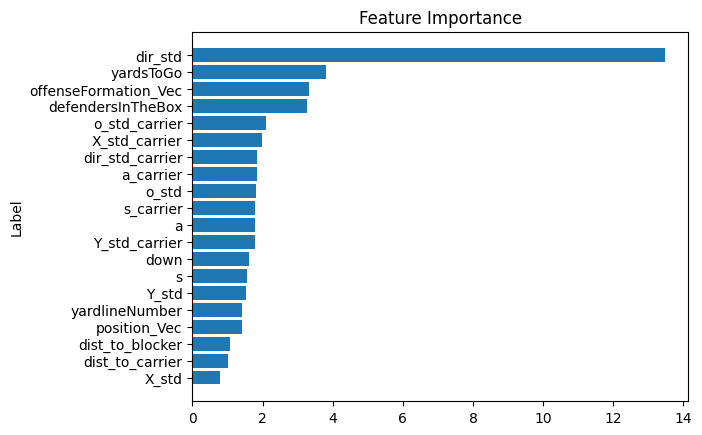

In [22]:
import matplotlib.pyplot as plt

plt.barh(feature_importance_table[0],feature_importance_table[1])
plt.title('Feature Importance')
plt.ylabel('Label')
plt.savefig('./featureimportance.png',bbox_inches='tight')

In [ ]:
!pwd

/content/drive/MyDrive/BDB 2024


In [23]:
predictions.write.option("header",True).mode('overwrite').parquet("./predictions.parquet")